In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
#from get_dataset import get_scan, scan_pading, save_seg_imgs
from tensorflow.keras.models import model_from_json, load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat

/home/dudongsu/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dudongsu/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dudongsu/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dudongsu/anaconda3/envs/tf_gpu/lib

In [2]:
model =  load_model('Data_v3/Checkpoints/GAN-Models/Generator/model.h5')

In [5]:
model =  load_model('Data_v3/Model_UnetDense/model.h5')

In [6]:
model.load_weights('Data_v3/Model_UnetDense/best_weights.h5')

In [3]:
def get_outline(data):
    if(data.ndim!=4):
        print('need to be a 4 dimension bool matrix!')
        return
    contour = np.zeros(data.shape)
    for i in range(0,data.shape[3]):
        for row in range(data.shape[1]):
            for col in range(data.shape[2]):
                if(data[0][row][col][i]==True and (col==0 or data[0][row][col-1][i]==False)):
                    contour[0][row][col][i] = i+1
                if(data[0][row][col][i]==True and (col==data.shape[2]-1 or data[0][row][col+1][i]==False)):
                    contour[0][row][col][i] = i+1
    
    for i in range(0,data.shape[3]):
        for col in range(data.shape[2]):
            for row in range(data.shape[1]):
                if(data[0][row][col][i]==True and (row==0 or data[0][row-1][col][i]==False)):
                    contour[0][row][col][i] = i+1
                if(data[0][row][col][i]==True and (col==data.shape[1]-1 or data[0][row+1][col][i]==False)):
                    contour[0][row][col][i] = i+1
    return contour

In [27]:
training_path='Data_v2/npy_dataset/training_npy_dataset'
train_XY=np.load(training_path+'/batch_105.npy')
X_train, dose=train_XY[:,:,:,0:13],train_XY[:,:,:,13:14]
X_train = np.array(X_train, dtype='bool')
print(X_train.shape)
print(dose.shape)
type(X_train)
contour  = get_outline(X_train)
print(contour.shape)

(1, 128, 256, 13)
(1, 128, 256, 1)
(1, 128, 256, 13)


In [30]:
dose_map = np.squeeze(dose)

contour = np.squeeze(contour)
print(contour.size)

plt.imshow(contour[:,:,1], cmap='Blues', alpha=0.3)

plt.imshow(dose_map, cmap='gray')

plt.colorbar()
masked_data = np.ma.masked_where(contour[:,:,6] < 1, contour[:,:,2])
plt.imshow(masked_data, cmap='rainbow')
masked_data = np.ma.masked_where(contour[:,:,3] < 1, contour[:,:,3])
plt.imshow(masked_data, cmap='rainbow')

plt.show()

425984


In [4]:
class IndexTracker(object):
    def __init__(self, ax, X,fig,bmin,bmax):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.fig = fig
        self.slices, row, cols = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[self.ind,:,:],cmap='jet',vmin=bmin, vmax=bmax)
        fig.colorbar(self.im, ax=self.ax )
      #  self.im.colorbar()
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind,:, :])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

structure and dose loaded


<IPython.core.display.Javascript object>


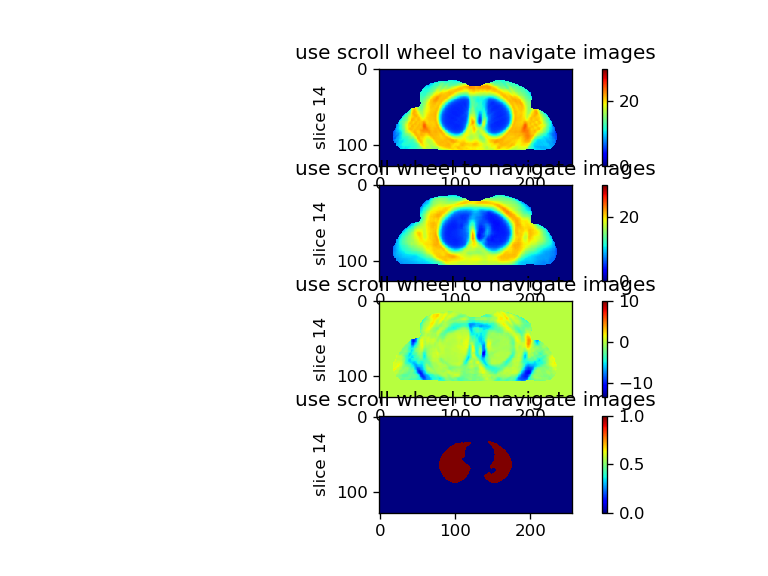

In [10]:
file_path='Data_v3/test/data_LARASH_NEW.mat'
f = loadmat(file_path)
structure = f['structset_2d_channel']
dose_true = f['doseset_2d']
dose_true = np.expand_dims(dose_true,axis=3)
structure = np.array(structure, dtype='float32')
dose_true = np.array(dose_true).astype('float32')

# crop the dose outside body
mask = structure>0
mask_Body = np.squeeze(mask[:,:,:,0])
mask_Body = np.expand_dims(mask_Body,axis=3)
dose_true = np.multiply(dose_true, mask_Body)

print('structure and dose loaded')
dose_predict = np.zeros(dose_true.shape)
dose_diff = np.zeros(dose_true.shape)
for i in range(0,dose_true.shape[0]):
    structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
    dose_plane = model.predict(structure_plane)
    dose_predict[i,:,:,:]=dose_plane

dose_predict = np.multiply(dose_predict, mask_Body)
mask_Lung = np.squeeze(mask[:,:,:,7])
mask_Lung = mask_Lung.flatten()
dose_flat = dose_predict.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_Lung_predict = dose_masked.compressed()

#dose_predict = dose_predict/dose_Lung_predict.mean()*8.0

dose_flat = dose_true.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_Lung_true = dose_masked.compressed()

max_dose=dose_flat.max()
dose_true = dose_true/dose_Lung_true.mean()*8.0

### plot organ on figure 4
organ = 7
mask_organ = np.squeeze(mask[:,:,:,organ])
mask_organ = np.array(mask_organ).astype('float32')


dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)


fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1)
tracker1 = IndexTracker(ax1, np.squeeze(dose_true), fig,0,30)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, np.squeeze(dose_predict), fig,0,30)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, np.squeeze(dose_diff), fig,dose_diff.min(),dose_diff.max())
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
tracker4 = IndexTracker(ax4, mask_organ, fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)

plt.show()                                                    
     

In [6]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1]*imageA.shape[2]*imageA.shape[3])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

the MSE before dose normalization to lung is 3.3167801663055947
true lung dose mean 7.999999
the MSE after dose normalization to lung is 3.303230857990034
True mean organ dose is:  20.384348
Predict mean organ dose is:  21.885877660040318
the dose difference is: 7.51%
True max organ dose is:  21.499655
Predict max organ dose is:  23.70366096496582
the dose difference is: 11.02%


<IPython.core.display.Javascript object>


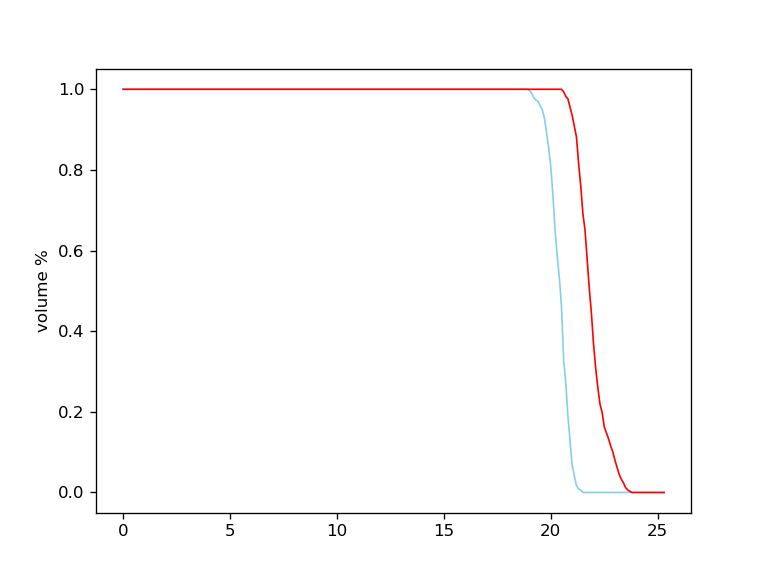

In [47]:
f = loadmat('Data_v3/test/data_PEREZ_NEW.mat')
structure = f['structset_2d_channel']
dose_true = f['doseset_2d']
dose_true = np.expand_dims(dose_true,axis=3)
organ = 3
structure = np.array(structure, dtype='float32')
dose_true = np.array(dose_true).astype('float32')
mask = structure>0
mask_Body = np.squeeze(mask[:,:,:,0])
mask_Body = np.expand_dims(mask_Body,axis=3)
#dose_true = np.multiply(dose_true, mask_Body)
mask_Lung = np.squeeze(mask[:,:,:,7])


dose_predict = np.zeros(dose_true.shape)
dose_diff = np.zeros(dose_true.shape)
for i in range(0,dose_true.shape[0]):
    structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
    dose_plane = model.predict(structure_plane)
    dose_predict[i,:,:,:]=dose_plane
dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)

print("the MSE before dose normalization to lung is", mse(dose_true, dose_predict))

mask_Lung = mask_Lung.flatten()
dose_flat = dose_true.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_true_Lung = dose_masked.compressed()
dose_true = dose_true/dose_Lung_true.mean()*8.0

dose_flat = dose_true.flatten()
mask_organ = mask_Lung.flatten()
dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
dose_organ = dose_masked.compressed()
print('true lung dose mean', dose_organ.mean())


dose_flat = dose_predict.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_predict_Lung = dose_masked.compressed()
#dose_predict = dose_predict/dose_Lung_predict.mean()*8.0

print("the MSE after dose normalization to lung is", mse(dose_true, dose_predict))
      
dose_flat = dose_true.flatten()
dose_flat_predict = dose_predict.flatten()
mask = structure>0
mask_organ = np.squeeze(mask[:,:,:,organ])
mask_organ = mask_organ.flatten()
dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
dose_organ = dose_masked.compressed()

dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat_predict)
dose_organ_predict = dose_masked.compressed()
DVH_inv = 0.1
DVH_bin = int(dose_organ.max()/DVH_inv+40)
DVH_true = np.zeros(DVH_bin)
DVH_predict = np.zeros(DVH_bin)
dose_bin = np.zeros(DVH_bin)
print('True mean organ dose is: ', dose_organ.mean())
print('Predict mean organ dose is: ', dose_organ_predict.mean())
print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.mean()-dose_organ.mean())/20))
print('True max organ dose is: ', dose_organ.max())
print('Predict max organ dose is: ', dose_organ_predict.max())
print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.max()-dose_organ.max())/20))

#for i in range(DVH_bin):
#    DVH_true[i] = sum(j > (i*DVH_inv) for j in dose_organ) / len(dose_organ)
#    DVH_predict[i] = sum(j > (i*DVH_inv) for j in dose_organ_predict) / len(dose_organ_predict)
#    dose_bin[i] = DVH_inv*i
dose_bin = np.arange(0,DVH_bin)*DVH_inv
dose_bin1 = np.arange(-1,DVH_bin)*DVH_inv
DVH, bin_edges = np.histogram(dose_organ,dose_bin1)
DVH_true = np.cumsum(DVH)
DVH_true = 1 - DVH_true/DVH_true.max()
DVH, bin_edges =  np.histogram(dose_organ_predict,dose_bin1)
DVH_predict = np.cumsum(DVH)
DVH_predict = 1-DVH_predict/DVH_predict.max()
    
fig = plt.figure()
plt.plot(dose_bin,DVH_true, color='skyblue', linewidth=1)
plt.plot(dose_bin,DVH_predict, color='red', linewidth=1)
plt.ylabel('volume %')
plt.show()

In [7]:
Dmean_true_all = np.zeros((5,10))
Dmean_predict_all = np.zeros((5,10))
Dmean_diff_all = np.zeros((5,10))

Dmax_true_all = np.zeros((5,10))
Dmax_predict_all = np.zeros((5,10))
Dmax_diff_all = np.zeros((5,10))

D95_true_all = np.zeros((5,10))
D95_predict_all = np.zeros((5,10))
D95_diff_all = np.zeros((5,10))

D5_true_all = np.zeros((5,10))
D5_predict_all = np.zeros((5,10))
D5_diff_all = np.zeros((5,10))

D98_true_all = np.zeros((5,10))
D98_predict_all = np.zeros((5,10))
D98_diff_all = np.zeros((5,10))

D2_true_all = np.zeros((5,10))
D2_predict_all = np.zeros((5,10))
D2_diff_all = np.zeros((5,10))

V20_true_all = np.zeros((5,10))
V20_predict_all = np.zeros((5,10))
V20_diff_all = np.zeros((5,10))


the MSE before dose normalization to lung is 5.6646845741747045
true lung dose mean 8.0
the MSE after dose normalization to lung is 5.9432534557031556
True mean organ dose is:  19.59769
Predict mean organ dose is:  18.214140903655117
the dose difference is: -6.92%
True max organ dose is:  23.53128
Predict max organ dose is:  23.463701248168945
the dose difference is: -0.34%
True mean organ dose is:  20.393126
Predict mean organ dose is:  20.10443742297245
the dose difference is: -1.44%
True max organ dose is:  24.998753
Predict max organ dose is:  24.711536407470703
the dose difference is: -1.44%
True mean organ dose is:  20.085602
Predict mean organ dose is:  20.272853810736475
the dose difference is: 0.94%
True max organ dose is:  21.695242
Predict max organ dose is:  21.60218620300293
the dose difference is: -0.47%
True mean organ dose is:  19.145557
Predict mean organ dose is:  19.29767577974903
the dose difference is: 0.76%
True max organ dose is:  25.223131
Predict max organ dose

<IPython.core.display.Javascript object>


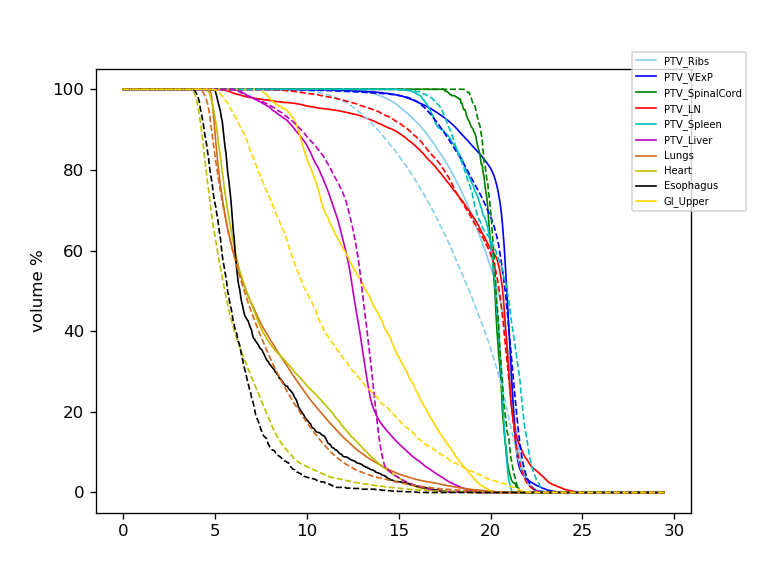

In [11]:
f = loadmat('Data_v3/test/data_LARASH_NEW.mat')
structure = f['structset_2d_channel']
dose_true = f['doseset_2d']
dose_true = np.expand_dims(dose_true,axis=3)
structure = np.array(structure, dtype='float32')
dose_true = np.array(dose_true).astype('float32')
mask = structure>0
mask_Body = np.squeeze(mask[:,:,:,0])
mask_Body = np.expand_dims(mask_Body,axis=3)
#dose_true = np.multiply(dose_true, mask_Body)
mask_Lung = np.squeeze(mask[:,:,:,7])


dose_predict = np.zeros(dose_true.shape)
dose_diff = np.zeros(dose_true.shape)
for i in range(0,dose_true.shape[0]):
    structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
    dose_plane = model.predict(structure_plane)
    dose_predict[i,:,:,:]=dose_plane
dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)

print("the MSE before dose normalization to lung is", mse(dose_true, dose_predict))

mask_Lung = mask_Lung.flatten()
dose_flat = dose_true.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_true_Lung = dose_masked.compressed()
dose_true = dose_true/dose_Lung_true.mean()*8.0

dose_flat = dose_true.flatten()
mask_organ = mask_Lung.flatten()
dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
dose_organ = dose_masked.compressed()
print('true lung dose mean', dose_organ.mean())


dose_flat = dose_predict.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_predict_Lung = dose_masked.compressed()
#dose_predict = dose_predict/dose_Lung_predict.mean()*8.0

print("the MSE after dose normalization to lung is", mse(dose_true, dose_predict))


organ_all = [1,2,3,4,5,6,7,8,9,10]
organ_name = ['PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper']
organ_number = 10
organ_true_mean = np.zeros(organ_number)
organ_true_max = np.zeros(organ_number)
D95_true = np.zeros(organ_number)
D5_true = np.zeros(organ_number)
D98_true = np.zeros(organ_number)
D2_true = np.zeros(organ_number)


organ_predict_mean = np.zeros(organ_number)
organ_predict_max = np.zeros(organ_number)
D95_predict = np.zeros(organ_number)
D5_predict = np.zeros(organ_number)
D98_predict = np.zeros(organ_number)
D2_predict = np.zeros(organ_number)

DVH_inv = 0.05
DVH_bin = int(29/DVH_inv+10)
DVH_true_all = np.zeros([organ_number,DVH_bin])
DVH_predict_all = np.zeros([organ_number,DVH_bin])
dose_bin = np.zeros(DVH_bin)
dose_bin = np.arange(0,DVH_bin)*DVH_inv
dose_bin1 = np.arange(-1,DVH_bin)*DVH_inv

for organ in organ_all:
    dose_flat = dose_true.flatten()
    dose_flat_predict = dose_predict.flatten()
    mask = structure>0
    mask_organ = np.squeeze(mask[:,:,:,organ])
    mask_organ = mask_organ.flatten()
    volume = len(mask_organ==True)
    dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
    dose_organ = dose_masked.compressed()
    organ_true_mean[organ-1] = dose_organ.mean()
    organ_true_max[organ-1] = dose_organ.max()
    
    dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat_predict)
    dose_organ_predict = dose_masked.compressed()
    organ_predict_mean[organ-1] = dose_organ_predict.mean()
    organ_predict_max[organ-1] = dose_organ_predict.max()
    
    DVH_true = np.zeros(DVH_bin)
    DVH_predict = np.zeros(DVH_bin)
    
    DVH, bin_edges = np.histogram(dose_organ,dose_bin1)
    DVH_true = np.cumsum(DVH)
    DVH_true = 1 - DVH_true/DVH_true.max()
    
    DVH, bin_edges =  np.histogram(dose_organ_predict,dose_bin1)
    DVH_predict = np.cumsum(DVH)
    DVH_predict = 1-DVH_predict/DVH_predict.max()
    
    index = np.argmin(np.abs(DVH_true-0.95))
    D95_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.95))
    D95_predict[organ-1] = index*DVH_inv
    
    index = np.argmin(np.abs(DVH_true-0.98))
    D98_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.98))
    D98_predict[organ-1] = index*DVH_inv
    
    index = np.argmin(np.abs(DVH_true-0.05))
    D5_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.05))
    D5_predict[organ-1] = index*DVH_inv
    
    index = np.argmin(np.abs(DVH_true-0.02))
    D2_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.02))
    D2_predict[organ-1] = index*DVH_inv
        
    DVH_true_all[organ-1,:] = DVH_true
    DVH_predict_all[organ-1,:]=DVH_predict
    
    DVH_true_all[organ-1,:] = DVH_true
    DVH_predict_all[organ-1,:] = DVH_predict
    
    
    
    print('True mean organ dose is: ', dose_organ.mean())
    print('Predict mean organ dose is: ', dose_organ_predict.mean())
    print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.mean()-dose_organ.mean())/20))
    print('True max organ dose is: ', dose_organ.max())
    print('Predict max organ dose is: ', dose_organ_predict.max())
    print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.max()-dose_organ.max())/20))

    
fig = plt.figure()
plt.plot(dose_bin,DVH_true_all[0,:]*100, color='skyblue', linewidth=1)
plt.plot(dose_bin,DVH_true_all[1,:]*100, color='b', linewidth=1)
plt.plot(dose_bin,DVH_true_all[2,:]*100, color='g', linewidth=1)
plt.plot(dose_bin,DVH_true_all[3,:]*100, color='r', linewidth=1)
plt.plot(dose_bin,DVH_true_all[4,:]*100, color='c', linewidth=1)
plt.plot(dose_bin,DVH_true_all[5,:]*100, color='m', linewidth=1)
plt.plot(dose_bin,DVH_true_all[6,:]*100, color='chocolate', linewidth=1)
plt.plot(dose_bin,DVH_true_all[7,:]*100, color='y', linewidth=1)
plt.plot(dose_bin,DVH_true_all[8,:]*100, color='k', linewidth=1)
plt.plot(dose_bin,DVH_true_all[9,:]*100, color='gold', linewidth=1)


plt.plot(dose_bin,DVH_predict_all[0,:]*100, color='skyblue', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[1,:]*100, color='b', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[2,:]*100, color='g', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[3,:]*100, color='r', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[4,:]*100, color='c', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[5,:]*100, color='m', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[6,:]*100, color='chocolate', linewidth=1,linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[7,:]*100, color='y', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[8,:]*100, color='k', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[9,:]*100, color='gold', linewidth=1, linestyle='dashed')


plt.ylabel('volume %')


plt.legend(['PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper'], loc='upper right',bbox_to_anchor=(1.1, 1.05),prop={'size': 6}) 
plt.show()



In [12]:
index = 0;
np.save('Data_v3/test/data_LARASH_predict_GAN_v2.npy', dose_predict)
Dmean_true_all[index,:] = organ_true_mean
Dmean_predict_all[index,:] = organ_predict_mean
Dmean_diff_all[index,:] = abs(np.divide((organ_predict_mean-organ_true_mean), organ_true_mean))
print('Dmean diff ',Dmean_diff_all[index,:]*100)

Dmax_true_all[index,:] = organ_true_max
Dmax_predict_all[index,:] = organ_predict_max
Dmax_diff_all[index,:] = abs(np.divide((organ_predict_max-organ_true_max), organ_true_max))
print('Dmax diff ',Dmax_diff_all[index,:]*100)

D95_true_all[index,:] = D95_true
D95_predict_all[index,:] = D95_predict
D95_diff_all[index,:] = abs(np.divide((D95_predict-D95_true), D95_true))
print('D95 diff ',D95_diff_all[index,:]*100)

D5_true_all[index,:] = D5_true
D5_predict_all[index,:] = D5_predict
D5_diff_all[index,:] = abs(np.divide((D5_predict-D5_true), D5_true))
print('D5 diff ',D5_diff_all[index,:]*100)

D98_true_all[index,:] = D98_true
D98_predict_all[index,:] = D98_predict
D98_diff_all[index,:] = abs(np.divide((D98_predict-D98_true), D98_true))
print('D98 diff ',D98_diff_all[index,:]*100)

D2_true_all[index,:] = D2_true
D2_predict_all[index,:] = D2_predict
D2_diff_all[index,:] = abs(np.divide((D2_predict-D2_true), D2_true))
print('D2 diff ',D2_diff_all[index,:]*100)

Dmean diff  [ 7.05975877  1.41561484  0.93226982  0.79453616  2.98184642  0.82244839
  6.46307088 22.39185534 20.03464029 18.29116592]
Dmax diff  [ 0.28718909  1.14892207  0.42892227  8.12977889  8.30585831  1.48931429
  5.97512817  4.84063556 16.69308814  9.55309305]
D95 diff  [16.77631579  1.78571429  3.50404313 20.44444444  3.89221557  3.08641975
  5.10204082 17.17171717 20.         33.89830508]
D5 diff  [ 0.2293578   0.92165899  1.19047619  3.76106195  6.68257757 14.15929204
 12.16216216 26.4604811  31.52173913  1.59574468]
D98 diff  [18.66197183  0.64935065  4.12087912 63.76811594  3.07692308  1.42857143
  6.25       16.84210526 19.60784314 31.44654088]
D2 diff  [ 0.45146727  1.11607143  0.23419204  5.76923077  7.60095012 12.74238227
 10.37463977 14.74358974 28.20512821  7.73195876]


In [25]:
np.savez('Data_v3/test/DVH_parameter_GAN_true.npz', Dmean_true_all, Dmax_true_all, D95_true_all, D5_true_all, D98_true_all, D2_true_all)
np.savez('Data_v3/test/DVH_parameter_GAN_predict.npz', Dmean_predict_all, Dmax_predict_all, D95_predict_all, D5_predict_all, D98_predict_all, D2_predict_all)
np.savez('Data_v3/test/DVH_parameter_GAN_diff.npz', Dmean_diff_all, Dmax_diff_all, D95_diff_all, D5_diff_all, D98_diff_all, D2_diff_all)


In [26]:
for i in range(10):
    print ('the organ',organ_name[i],'mean diff is', np.mean(Dmean_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'mean diff std', np.std(Dmean_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'max diff is', np.mean(Dmax_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'max diff is std', np.std(Dmax_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D95 diff is', np.mean(D95_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D95 diff is std', np.std(D95_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D5 diff is', np.mean(D5_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D5 diff is std', np.std(D5_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D98 diff is', np.mean(D98_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D98 diff is std', np.std(D98_diff_all[0:3,i])*100)

the organ PTV_Ribs mean diff is 2.1100593786767052
the organ PTV_Ribs mean diff std 1.5650147280530067
the organ PTV_Ribs max diff is 2.8507687923871887
the organ PTV_Ribs max diff is std 1.8394802765041967
the organ PTV_Ribs D95 diff is 5.174956622325049
the organ PTV_Ribs D95 diff is std 4.249243391611951
the organ PTV_Ribs D5 diff is 0.9128405857959468
the organ PTV_Ribs D5 diff is std 0.97632896381967
the organ PTV_Ribs D98 diff is 6.197987198725864
the organ PTV_Ribs D98 diff is std 4.842409808053006
the organ PTV_VExP mean diff is 1.719557419020833
the organ PTV_VExP mean diff std 0.9283243427417343
the organ PTV_VExP max diff is 3.772513286846608
the organ PTV_VExP max diff is std 3.952190123373827
the organ PTV_VExP D95 diff is 4.3307515242005765
the organ PTV_VExP D95 diff is std 3.6727733597207783
the organ PTV_VExP D5 diff is 1.2234176969518562
the organ PTV_VExP D5 diff is std 1.4159027244040994
the organ PTV_VExP D98 diff is 4.9431865547407305
the organ PTV_VExP D98 diff i

In [12]:
print(organ_name)
print(D5_true)
print(D5_predict)

['PTV_Ribs', 'PTV_VExP', 'PTV_SpinalCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'Lungs', 'Heart', 'Esophagus', 'GI_Upper']
[22.55 22.55 22.   22.7  23.45 14.65 14.   14.6  11.7  21.45]
[22.5  22.35 22.1  22.4  23.45 15.   14.3  15.25 11.65 22.35]


In [36]:
np.save('Data_v2/validation/data_Colon_predict.npy', dose_predict)